<a href="https://colab.research.google.com/github/Mandar117/3D-Object-Detection-and-Tracking-for-Autonomous-Vehicles/blob/main/3D_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kitti Dataset Setup**

In [1]:


import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
from tqdm.notebook import tqdm

import kagglehub

# Download latest version
path = kagglehub.dataset_download("klemenko/kitti-dataset")

print("Path to dataset files:", path)

100%|██████████| 22.5G/22.5G [03:56<00:00, 102MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/klemenko/kitti-dataset/versions/1


In [2]:
# Set paths
CALIB_PATH = os.path.join(path, 'data_object_calib/training/calib')
LEFT_IMG_PATH = os.path.join(path, 'data_object_image_2/training/image_2')
RIGHT_IMG_PATH = os.path.join(path, 'data_object_image_3/training/image_3')
LABEL_PATH = os.path.join(path, 'data_object_label_2/training/label_2')

# Verify path
print(f"Calibration path exists: {os.path.exists(CALIB_PATH)}")
print(f"Left image path exists: {os.path.exists(LEFT_IMG_PATH)}")
print(f"Right image path exists: {os.path.exists(RIGHT_IMG_PATH)}")
print(f"Label path exists: {os.path.exists(LABEL_PATH)}")

# Get file list
if os.path.exists(LEFT_IMG_PATH):
    image_files = sorted([f for f in os.listdir(LEFT_IMG_PATH) if f.endswith('.png')])
    print(f"Found {len(image_files)} images")
    if len(image_files) > 0:
        print(f"Example image file: {image_files[0]}")

Calibration path exists: True
Left image path exists: True
Right image path exists: True
Label path exists: True
Found 7481 images
Example image file: 000000.png


Visualizing a sample image (if available)...


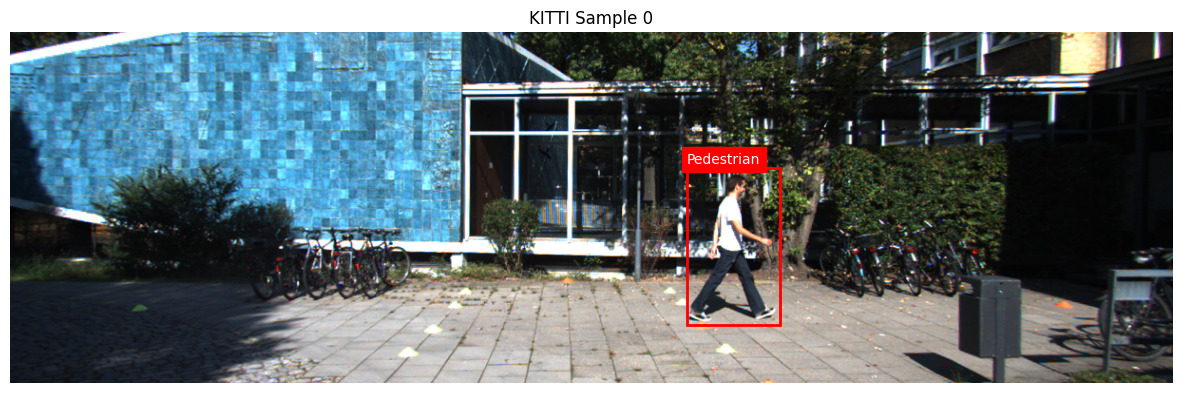

Found 1 objects in this frame
Object types:
  - Pedestrian: 1

Analyzing dataset (this may take a while)...


Analyzing dataset:   0%|          | 0/7481 [00:00<?, ?it/s]

Dataset Statistics:
Total frames: 7481
Total objects: 51865
Object types distribution:


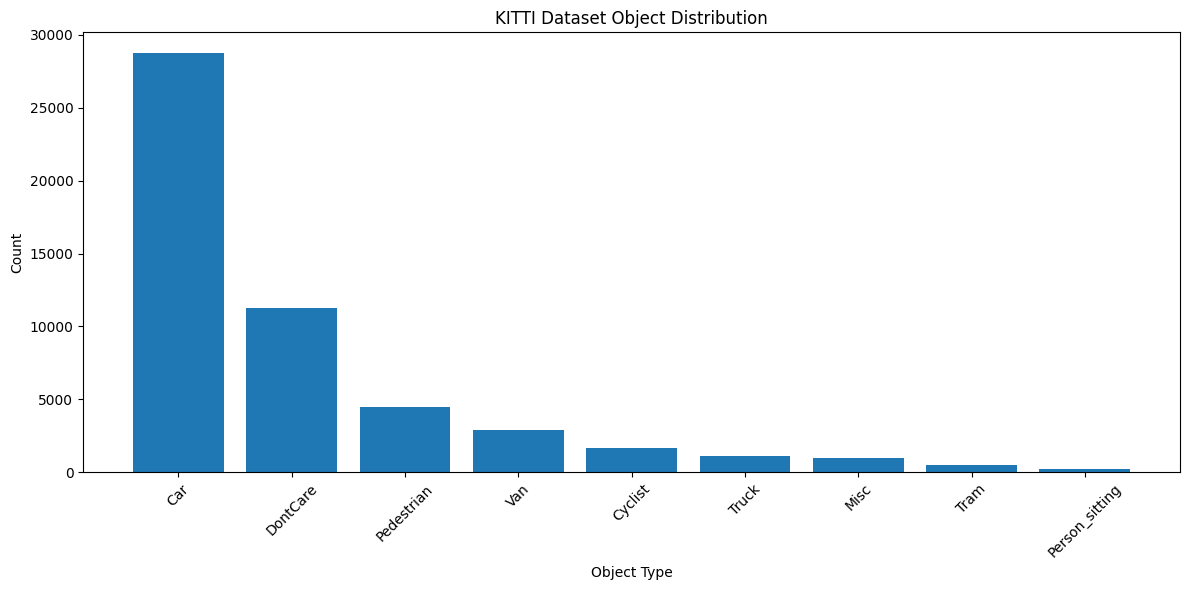

In [3]:
# Functions to load KITTI data

def read_calibration(calib_file_path):
    """Read calibration file and return camera parameters"""
    calib_data = {}
    with open(calib_file_path, 'r') as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            calib_data[key] = np.array([float(x) for x in value.split()])

    # Extract projection matrix for left camera (P2)
    if 'P2' in calib_data:
        P2 = calib_data['P2'].reshape(3, 4)
        calib_data['P2_matrix'] = P2

    return calib_data

def read_labels(label_file_path):
    """Read object labels"""
    objects = []
    with open(label_file_path, 'r') as f:
        for line in f.readlines():
            values = line.split()
            obj = {
                'type': values[0],
                'truncated': float(values[1]),
                'occluded': int(values[2]),
                'alpha': float(values[3]),
                'bbox': [float(values[4]), float(values[5]), float(values[6]), float(values[7])],
                'dimensions': [float(values[8]), float(values[9]), float(values[10])],
                'location': [float(values[11]), float(values[12]), float(values[13])],
                'rotation_y': float(values[14])
            }
            objects.append(obj)
    return objects

def visualize_sample(idx):
    """Visualize a sample with bounding boxes"""
    file_idx = f"{idx:06d}"

    # Load images
    left_img_path = os.path.join(LEFT_IMG_PATH, f"{file_idx}.png")
    right_img_path = os.path.join(RIGHT_IMG_PATH, f"{file_idx}.png")

    if not os.path.exists(left_img_path):
        print(f"Image file {left_img_path} does not exist!")
        return

    left_img = cv2.imread(left_img_path)
    left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)

    # Load labels
    label_file = os.path.join(LABEL_PATH, f"{file_idx}.txt")
    if os.path.exists(label_file):
        objects = read_labels(label_file)
    else:
        print(f"Label file {label_file} does not exist!")
        objects = []

    # Visualize
    plt.figure(figsize=(15, 10))
    plt.imshow(left_img)

        # Draw 2D bounding boxes
    for obj in objects:
        if obj['type'] in ['Car', 'Pedestrian', 'Cyclist']:  # Filter for main objects
            bbox = obj['bbox']
            rect = plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                edgecolor='r',
                linewidth=2
            )
            plt.gca().add_patch(rect)
            plt.text(
                bbox[0], bbox[1] - 5,
                f"{obj['type']}",
                color='white',
                backgroundcolor='red',
                fontsize=10
            )

    plt.title(f"KITTI Sample {idx}")
    plt.axis('off')
    plt.show()

    # Print object information
    print(f"Found {len(objects)} objects in this frame")
    object_types = {}
    for obj in objects:
        obj_type = obj['type']
        if obj_type in object_types:
            object_types[obj_type] += 1
        else:
            object_types[obj_type] = 1

    print("Object types:")
    for obj_type, count in object_types.items():
        print(f"  - {obj_type}: {count}")

# Creating a simple dataset statistics function
def analyze_dataset():
    """Analyze the dataset and print statistics"""
    if not os.path.exists(LABEL_PATH):
        print("Label path does not exist!")
        return

    label_files = [f for f in os.listdir(LABEL_PATH) if f.endswith('.txt')]
    total_objects = 0
    object_types = {}

    for label_file in tqdm(label_files, desc="Analyzing dataset"):
        objects = read_labels(os.path.join(LABEL_PATH, label_file))
        total_objects += len(objects)

        for obj in objects:
            obj_type = obj['type']
            if obj_type in object_types:
                object_types[obj_type] += 1
            else:
                object_types[obj_type] = 1

    print(f"Dataset Statistics:")
    print(f"Total frames: {len(label_files)}")
    print(f"Total objects: {total_objects}")
    print("Object types distribution:")

    # Create a DataFrame for better visualization
    stats_df = pd.DataFrame({
        'Object Type': list(object_types.keys()),
        'Count': list(object_types.values())
    })
    stats_df = stats_df.sort_values('Count', ascending=False)

    # Plot object distribution
    plt.figure(figsize=(12, 6))
    plt.bar(stats_df['Object Type'], stats_df['Count'])
    plt.title('KITTI Dataset Object Distribution')
    plt.xlabel('Object Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return stats_df

print("Visualizing a sample image (if available)...")
if os.path.exists(LEFT_IMG_PATH) and len(os.listdir(LEFT_IMG_PATH)) > 0:
    visualize_sample(0)  # Visualize the first sample
else:
    print("Cannot visualize samples - check path to images")

print("\nAnalyzing dataset (this may take a while)...")
if os.path.exists(LABEL_PATH):
    stats_df = analyze_dataset()
else:
    print("Cannot analyze dataset - check path to labels")

# **Step 2: YOLOv8 Training Setup**

In [4]:
"""
YOLOv8 Training for KITTI Dataset
================================
This notebook sets up YOLOv8 training for the KITTI dataset
"""
!pip install ultralytics
import os
import cv2
import yaml
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import drive
from ultralytics import YOLO  # Install with: !pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

KITTI to YOLO conversion...
Found 7481 images
Train set: 5984 images
Validation set: 1497 images


Processing train set:   0%|          | 0/5984 [00:00<?, ?it/s]

Processing val set:   0%|          | 0/1497 [00:00<?, ?it/s]

Created dataset.yaml at /kaggle/working/yolo_format/dataset.yaml
Conversion completed!

Training YOLOv8 model...


Ultralytics 8.3.178 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_format/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretr

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               


  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 95.5±13.4 MB/s, size: 817.0 KB)


train: Scanning /kaggle/working/yolo_format/labels/train... 5984 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5984/5984 [00:36<00:00, 161.79it/s]


train: New cache created: /kaggle/working/yolo_format/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 94.6±27.2 MB/s, size: 764.4 KB)


val: Scanning /kaggle/working/yolo_format/labels/val... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:09<00:00, 157.25it/s]

val: New cache created: /kaggle/working/yolo_format/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      1.16G      1.375      1.521      1.088         78        640: 100%|██████████| 748/748 [03:21<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:27<00:00,  3.37it/s]


                   all       1497       8214      0.428       0.41      0.404      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.23G      1.265      1.047       1.06         76        640: 100%|██████████| 748/748 [03:14<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:25<00:00,  3.66it/s]


                   all       1497       8214       0.51      0.475      0.471      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.35G      1.213     0.9295      1.042         93        640: 100%|██████████| 748/748 [03:12<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


                   all       1497       8214       0.63      0.507      0.556      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.37G      1.157     0.8415      1.021         75        640: 100%|██████████| 748/748 [03:12<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


                   all       1497       8214      0.717       0.57      0.632        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.39G      1.097     0.7702      1.001         95        640: 100%|██████████| 748/748 [03:11<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


                   all       1497       8214      0.744      0.612      0.682      0.443

5 epochs completed in 0.308 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.178 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


                   all       1497       8214       0.74      0.613      0.682      0.443
               Vehicle       1358       6414      0.855      0.832      0.899      0.654
                 Truck        213        222      0.762      0.809      0.858      0.641
            Pedestrian        384        952      0.852      0.461      0.631      0.334
               Cyclist        239        339       0.66      0.543      0.589      0.314
                  Tram         72         97      0.667       0.68      0.705      0.445
                  Misc        154        190      0.644      0.353      0.413       0.27
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.178 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3480.2±780.4 MB/s, size: 749.0 KB)


val: Scanning /kaggle/working/yolo_format/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 188/188 [00:25<00:00,  7.28it/s]


                   all       1497       8214      0.739      0.612      0.682      0.443
               Vehicle       1358       6414      0.855      0.832      0.899      0.654
                 Truck        213        222      0.762      0.807      0.858      0.641
            Pedestrian        384        952       0.85       0.46       0.63      0.333
               Cyclist        239        339      0.659       0.54      0.588      0.317
                  Tram         72         97      0.669       0.68      0.705      0.445
                  Misc        154        190      0.639      0.353      0.413      0.269
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train2
Validation results: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79a3c4e19590>
cur

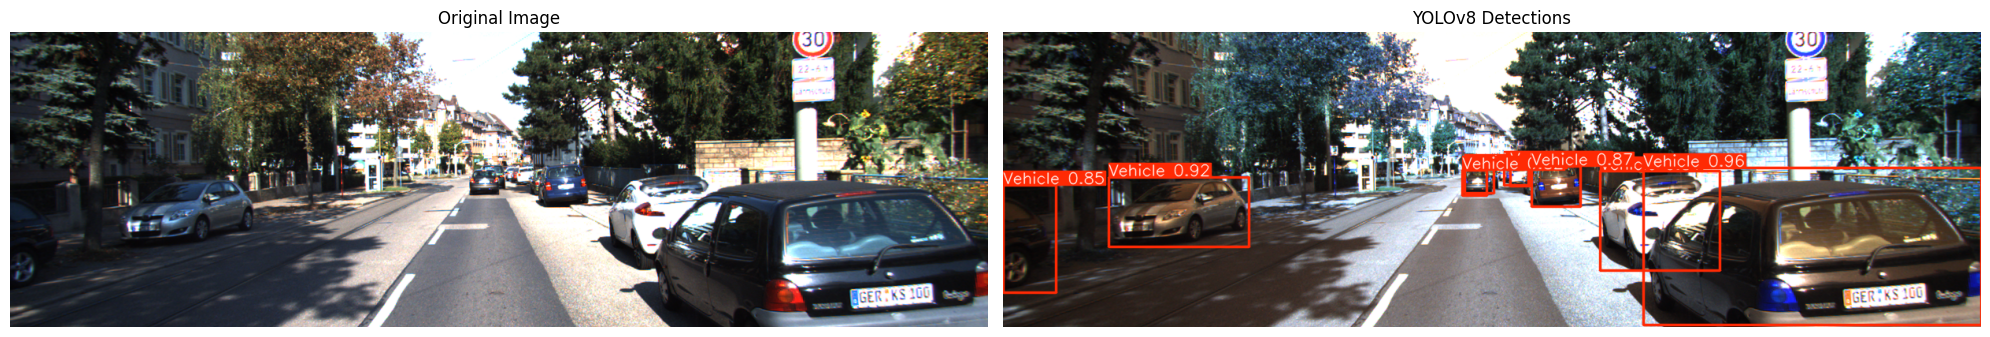

In [5]:
# Create YOLO dataset structure
YOLO_DATASET_PATH = os.path.join('/kaggle/working', 'yolo_format')
os.makedirs(os.path.join(YOLO_DATASET_PATH, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATASET_PATH, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATASET_PATH, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATASET_PATH, 'labels', 'val'), exist_ok=True)


# Define class mapping
kitti_classes = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']
# Map to simplified classes for YOLOv8
yolo_class_map = {
    'Car': 0,
    'Van': 0,  # Map to Car
    'Truck': 1,
    'Pedestrian': 2,
    'Person_sitting': 2,  # Map to Pedestrian
    'Cyclist': 3,
    'Tram': 4,
    'Misc': 5,
    'DontCare': -1  # Ignore
}

simplified_classes = ['Vehicle', 'Truck', 'Pedestrian', 'Cyclist', 'Tram', 'Misc']

def convert_kitti_to_yolo():
    """Convert KITTI format annotations to YOLO format"""
    if not os.path.exists(LEFT_IMG_PATH) or not os.path.exists(LABEL_PATH):
        print("Image path or label path does not exist!")
        return

    # Get all image files
    image_files = sorted([f for f in os.listdir(LEFT_IMG_PATH) if f.endswith('.png')])
    print(f"Found {len(image_files)} images")

    # Split into train/val (80/20 split)
    np.random.seed(42)  # For reproducibility
    np.random.shuffle(image_files)
    split_idx = int(len(image_files) * 0.8)
    train_files = image_files[:split_idx]
    val_files = image_files[split_idx:]

    print(f"Train set: {len(train_files)} images")
    print(f"Validation set: {len(val_files)} images")

    # Process train files
    process_files(train_files, 'train')

    # Process val files
    process_files(val_files, 'val')

    # Create dataset.yaml file
    create_dataset_yaml()

    print("Conversion completed!")

def process_files(files, subset):
    """Process files for the given subset (train/val)"""
    for file in tqdm(files, desc=f"Processing {subset} set"):
        # Get base filename without extension
        base_name = os.path.splitext(file)[0]

        # Copy image file
        src_img_path = os.path.join(LEFT_IMG_PATH, file)
        dst_img_path = os.path.join(YOLO_DATASET_PATH, 'images', subset, file)

        img = cv2.imread(src_img_path)
        if img is None:
            print(f"Warning: Could not read image {src_img_path}")
            continue

        cv2.imwrite(dst_img_path, img)

        # Get image dimensions for normalization
        img_height, img_width = img.shape[:2]

        # Convert annotation
        label_file = os.path.join(LABEL_PATH, f"{base_name}.txt")
        if not os.path.exists(label_file):
            print(f"Warning: Label file {label_file} does not exist")
            continue

        convert_annotation(label_file, subset, base_name, img_width, img_height)

def convert_annotation(label_file, subset, base_name, img_width, img_height):
    """Convert a single annotation file to YOLO format"""
    yolo_labels = []

    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            obj_class = parts[0]

            if yolo_class_map.get(obj_class, -1) == -1:
                continue

            # Extract bounding box
            x1 = float(parts[4])
            y1 = float(parts[5])
            x2 = float(parts[6])
            y2 = float(parts[7])

            # Convert to YOLO format (normalized center, width, height)
            x_center = ((x1 + x2) / 2) / img_width
            y_center = ((y1 + y2) / 2) / img_height
            width = (x2 - x1) / img_width
            height = (y2 - y1) / img_height

            yolo_class = yolo_class_map.get(obj_class, -1)
            if yolo_class == -1:
                continue

            yolo_labels.append(f"{yolo_class} {x_center} {y_center} {width} {height}")

    # Write YOLO format label file
    dst_label_path = os.path.join(YOLO_DATASET_PATH, 'labels', subset, f"{base_name}.txt")
    with open(dst_label_path, 'w') as f:
        f.write('\n'.join(yolo_labels))

def create_dataset_yaml():
    """Create YOLOv8 dataset.yaml file"""
    yaml_content = {
        'path': YOLO_DATASET_PATH,
        'train': 'images/train',
        'val': 'images/val',
        'names': {i: name for i, name in enumerate(simplified_classes)}
    }

    yaml_path = os.path.join(YOLO_DATASET_PATH, 'dataset.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f, sort_keys=False)

    print(f"Created dataset.yaml at {yaml_path}")

def train_yolov8(epochs=20, batch_size=16, img_size=640):
    """Train YOLOv8 on the KITTI dataset"""
    # Check if dataset is prepared
    yaml_path = os.path.join(YOLO_DATASET_PATH, 'dataset.yaml')
    if not os.path.exists(yaml_path):
        print("Dataset not prepared! Run convert_kitti_to_yolo() first.")
        return

    model = YOLO('yolov8n.pt')

    # Train the model
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        batch=batch_size,
        imgsz=img_size,
        patience=5,  # Early stopping patience
        save=True,  # Save checkpoints
        device='0' if torch.cuda.is_available() else 'cpu'
    )

    # Validate the model
    val_results = model.val()
    print(f"Validation results: {val_results}")

    return model

def test_model(model, img_path=None):
    """Test trained model on a sample image"""
    if img_path is None:
        # Get a random validation image
        val_img_dir = os.path.join(YOLO_DATASET_PATH, 'images', 'val')
        img_files = os.listdir(val_img_dir)
        if not img_files:
            print("No validation images found!")
            return
        img_path = os.path.join(val_img_dir, np.random.choice(img_files))

    # Run prediction
    results = model.predict(img_path, conf=0.25)

    # Show results
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Original image
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Image with detections
    for r in results:
        plotted_img = r.plot()
        ax[1].imshow(plotted_img)
        ax[1].set_title('YOLOv8 Detections')
        ax[1].axis('off')

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Check necessary imports
    try:
        import torch
    except ImportError:
        print("Installing torch...")
        !pip install torch torchvision
        import torch

    try:
        from ultralytics import YOLO
    except ImportError:
        print("Installing ultralytics...")
        !pip install ultralytics
        from ultralytics import YOLO

    print("KITTI to YOLO conversion...")
    convert_kitti_to_yolo()

    print("\nTraining YOLOv8 model...")
    # For testing with smaller epochs
    model = train_yolov8(epochs=5, batch_size=8)

    print("\nTesting model on sample image...")
    test_model(model)

# **Step 3: Stereo Depth Estimation for 3D Detection**

In [6]:
"""
Stereo Depth Estimation for 3D Detection
=======================================
This notebook implements stereo depth estimation for 3D object detection
"""

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
from tqdm.notebook import tqdm

CUDA available: True
CUDA device: Tesla T4
Testing stereo depth estimation on a sample image...
Using sample index: 0


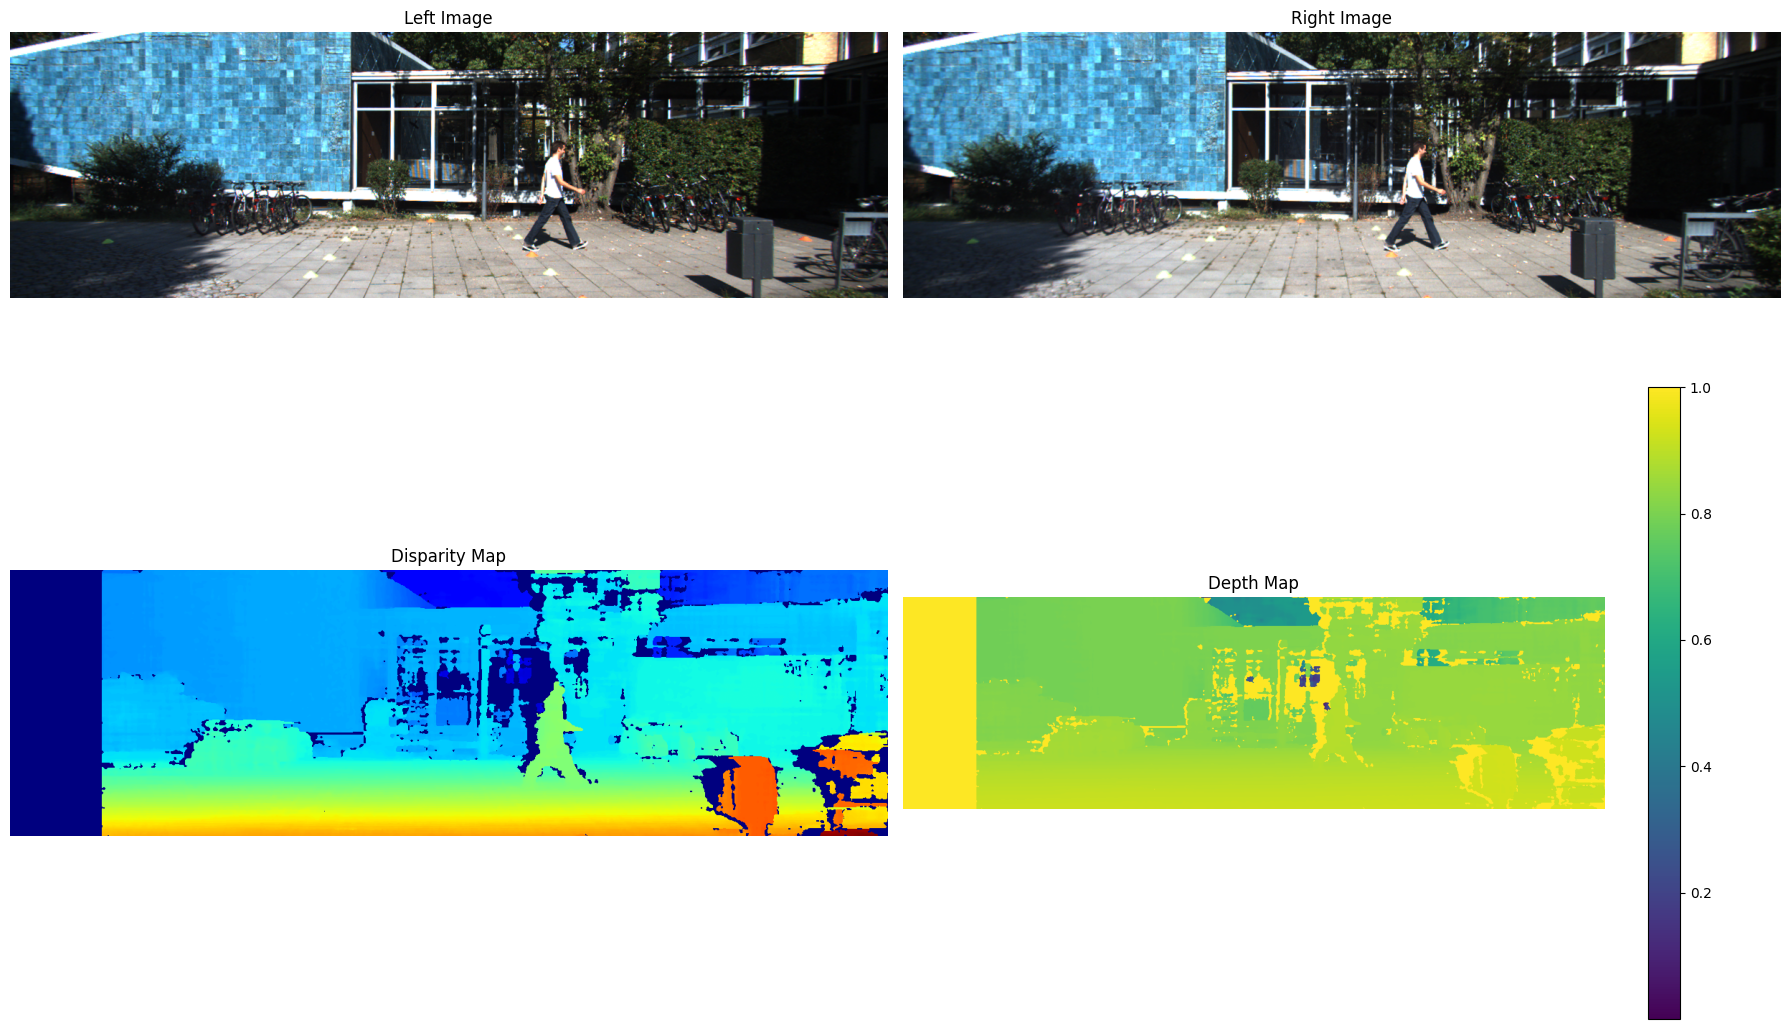

Depth statistics:
  - No valid depth values found.


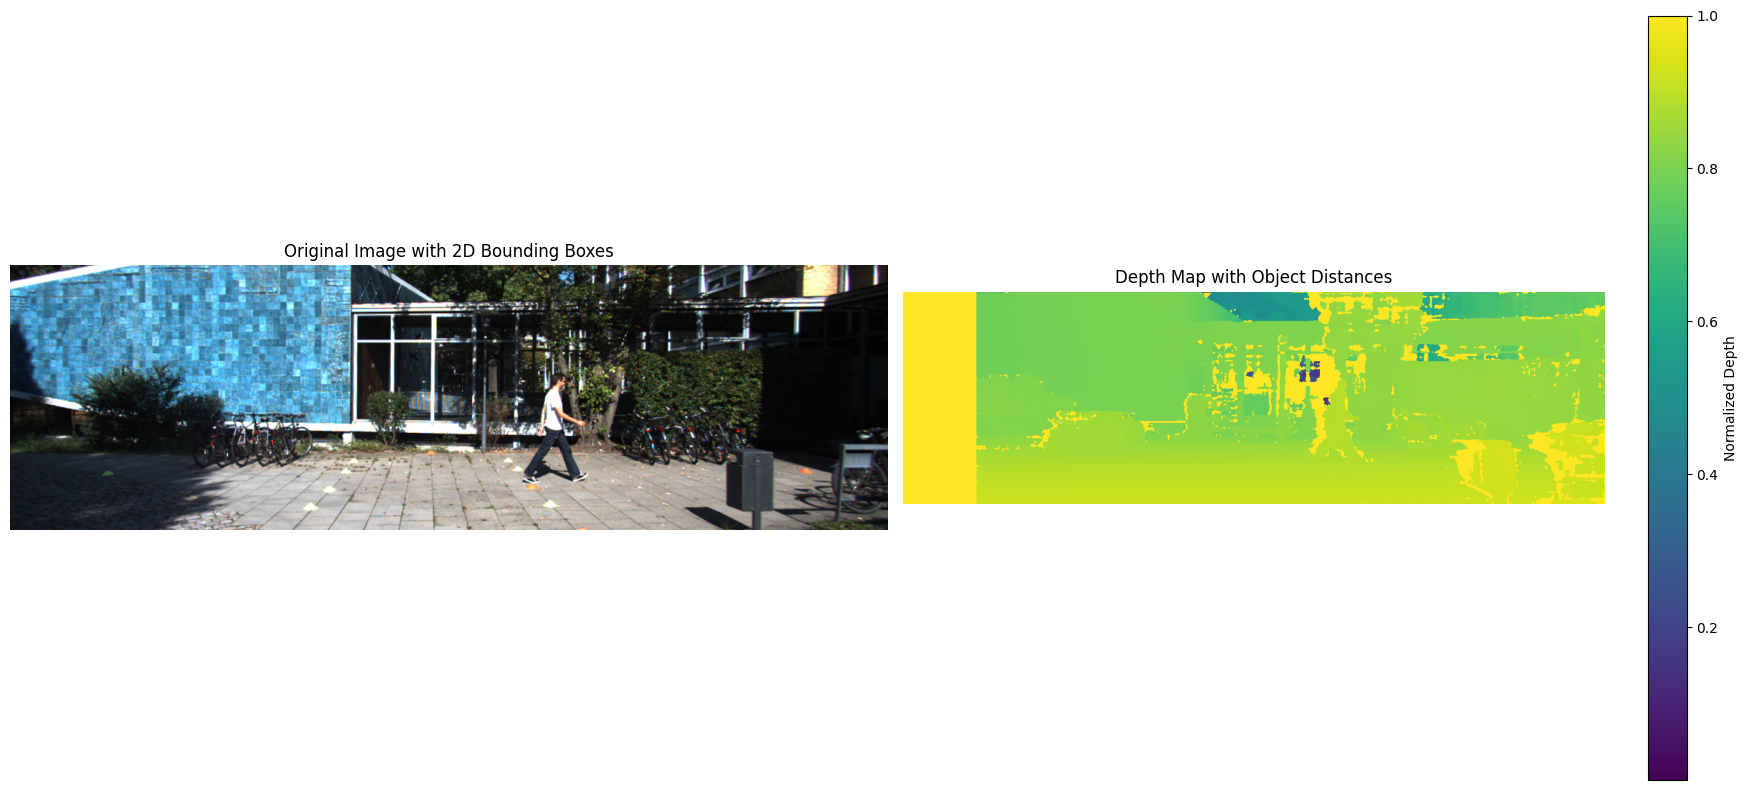

Distance Estimation Results:
--------------------------------------------------
| Object | GT Distance (m) | Estimated Distance (m) | Error (m) |
--------------------------------------------------
--------------------------------------------------


In [7]:
# Dataset paths

LEFT_IMG_PATH = os.path.join(path, 'data_object_image_2/training/image_2')
RIGHT_IMG_PATH = os.path.join(path, 'data_object_image_3/training/image_3')
CALIB_PATH = os.path.join(path, 'data_object_calib/training/calib')

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

def read_calibration(calib_file_path):
    """Read calibration file and extract camera parameters"""
    calib_data = {}
    with open(calib_file_path, 'r') as f:
        for line in f.readlines():
            if ':' in line:
                key, value = line.split(':', 1)
                calib_data[key] = np.array([float(x) for x in value.split()])

    # Extract projection matrices
    if 'P2' in calib_data:
        P2 = calib_data['P2'].reshape(3, 4)
        calib_data['P2_matrix'] = P2

    if 'P3' in calib_data:
        P3 = calib_data['P3'].reshape(3, 4)
        calib_data['P3_matrix'] = P3

    # Extract camera parameters for stereo
    if 'P2_matrix' in calib_data and 'P3_matrix' in calib_data:
        # Focal length (assuming same for both cameras)
        calib_data['focal_length'] = calib_data['P2_matrix'][0, 0]

        # Baseline (distance between cameras)
        calib_data['baseline'] = calib_data['P3_matrix'][0, 3] - calib_data['P2_matrix'][0, 3]

        # Principal points
        calib_data['cx1'] = calib_data['P2_matrix'][0, 2]
        calib_data['cy1'] = calib_data['P2_matrix'][1, 2]
        calib_data['cx2'] = calib_data['P3_matrix'][0, 2]
        calib_data['cy2'] = calib_data['P3_matrix'][1, 2]

    return calib_data

def compute_disparity_map(left_img, right_img, method='sgbm'):
    """Compute disparity map using either SGBM or BM algorithm"""
    # Convert to grayscale if color
    if len(left_img.shape) == 3:
        left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
        right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
    else:
        left_gray = left_img
        right_gray = right_img

    if method == 'sgbm':
        # SGBM Parameters
        window_size = 5
        min_disp = 0
        num_disp = 128  # Must be divisible by 16

        stereo = cv2.StereoSGBM_create(
            minDisparity=min_disp,
            numDisparities=num_disp,
            blockSize=window_size,
            P1=8 * 3 * window_size**2,
            P2=32 * 3 * window_size**2,
            disp12MaxDiff=1,
            uniquenessRatio=15,
            speckleWindowSize=100,
            speckleRange=2,
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
        )
    else:  # method == 'bm'
        # BM Parameters
        window_size = 15
        stereo = cv2.StereoBM_create(
            numDisparities=128,
            blockSize=window_size
        )

    # Compute disparity
    disparity = stereo.compute(left_gray, right_gray).astype(np.float32) / 16.0

    return disparity

def disparity_to_depth(disparity, focal_length, baseline):
    """Convert disparity map to depth map using the stereo camera formula"""
    mask = disparity > 0.1
    depth = np.zeros_like(disparity)

    # Check if there are any valid disparity values
    if np.any(mask):
        depth[mask] = (focal_length * baseline) / disparity[mask]

    # Filter out extreme values
    depth[depth > 80] = 80  # Max range for KITTI is typically 80m

    return depth

def generate_point_cloud(left_img, depth_map, focal_length, cx, cy):
    """Generate 3D point cloud from depth map and camera parameters"""
    # Get image dimensions
    h, w = depth_map.shape

    # Create mesh grid for pixel coordinates
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    # Calculate 3D points in camera coordinate system
    X = (xx - cx) * depth_map / focal_length
    Y = (yy - cy) * depth_map / focal_length
    Z = depth_map

    # Stack to create point cloud, reshape to Nx3
    points = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)

    # Get corresponding colors if available
    if len(left_img.shape) == 3:
        colors = left_img.reshape(-1, 3)
    else:
        colors = np.tile(left_img.reshape(-1, 1), (1, 3))

    return points, colors

def visualize_stereo_depth(idx):
    """Visualize stereo matching and depth estimation for a sample"""
    # Get file numbers with padding
    file_idx = f"{idx:06d}"

    # Load images
    left_img_path = os.path.join(LEFT_IMG_PATH, f"{file_idx}.png")
    right_img_path = os.path.join(RIGHT_IMG_PATH, f"{file_idx}.png")
    calib_file_path = os.path.join(CALIB_PATH, f"{file_idx}.txt")

    if not all(os.path.exists(p) for p in [left_img_path, right_img_path, calib_file_path]):
        print("Some files do not exist!")
        return

    # Read images
    left_img = cv2.imread(left_img_path)
    left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
    right_img = cv2.imread(right_img_path)
    right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

    # Read calibration
    calib_data = read_calibration(calib_file_path)

    if 'focal_length' not in calib_data or 'baseline' not in calib_data:
        print("Calibration data missing required parameters!")
        return

    # Compute disparity
    disparity = compute_disparity_map(left_img, right_img, method='sgbm')

    # Convert to depth
    depth_map = disparity_to_depth(disparity, calib_data['focal_length'], calib_data['baseline'])

    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Left image
    axes[0, 0].imshow(left_img)
    axes[0, 0].set_title('Left Image')
    axes[0, 0].axis('off')

    # Right image
    axes[0, 1].imshow(right_img)
    axes[0, 1].set_title('Right Image')
    axes[0, 1].axis('off')

    # Disparity map (color-mapped)
    disparity_normalized = cv2.normalize(disparity, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    axes[1, 0].imshow(disparity_normalized, cmap='jet')
    axes[1, 0].set_title('Disparity Map')
    axes[1, 0].axis('off')

    # Depth map (color-mapped)
    depth_normalized = cv2.normalize(depth_map, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    depth_vis = axes[1, 1].imshow(depth_normalized, cmap='viridis')
    axes[1, 1].set_title('Depth Map')
    axes[1, 1].axis('off')

    # Add colorbar for depth
    cbar = fig.colorbar(depth_vis, ax=axes[1, 1])

    plt.tight_layout()
    plt.show()

    # Print depth statistics
    print(f"Depth statistics:")

    valid_depths = depth_map[depth_map > 0]  # Get valid depths

    if valid_depths.size > 0:  # Check if there are valid depths
      print(f"  - Min depth: {np.min(depth_map[depth_map > 0]):.2f} meters")
      print(f"  - Max depth: {np.max(depth_map):.2f} meters")
      print(f"  - Mean depth: {np.mean(depth_map[depth_map > 0]):.2f} meters")
    else:
        print("  - No valid depth values found.")

    return disparity, depth_map

def create_pseudo_point_cloud(idx, visualize=True):
    """Create and visualize a pseudo point cloud from stereo depth"""
    # Get file numbers with padding
    file_idx = f"{idx:06d}"

    # Load images and calibration
    left_img_path = os.path.join(LEFT_IMG_PATH, f"{file_idx}.png")
    right_img_path = os.path.join(RIGHT_IMG_PATH, f"{file_idx}.png")
    calib_file_path = os.path.join(CALIB_PATH, f"{file_idx}.txt")

    if not all(os.path.exists(p) for p in [left_img_path, right_img_path, calib_file_path]):
        print("Some files do not exist!")
        return None

    # Read images
    left_img = cv2.imread(left_img_path)
    left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
    right_img = cv2.imread(right_img_path)
    right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

    # Read calibration
    calib_data = read_calibration(calib_file_path)

    # Compute disparity and depth
    disparity = compute_disparity_map(left_img, right_img, method='sgbm')
    depth_map = disparity_to_depth(disparity, calib_data['focal_length'], calib_data['baseline'])

    # Generate point cloud
    points, colors = generate_point_cloud(
        left_img,
        depth_map,
        calib_data['focal_length'],
        calib_data['cx1'],
        calib_data['cy1']
    )

    # Downsample point cloud for visualization (every Nth point)
    downsample_factor = 20  # Adjust based on performance
    points_downsampled = points[::downsample_factor]
    colors_downsampled = colors[::downsample_factor]

    if visualize:
        # For 3D plotting, we'll use matplotlib's 3D plotting
        from mpl_toolkits.mplot3d import Axes3D

        # Create figure
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        # Plot point cloud
        # We need to normalize colors from [0, 255] to [0, 1] for matplotlib
        colors_normalized = colors_downsampled / 255.0

        # Filter out points that are too far or have zero depth
        mask = (points_downsampled[:, 2] > 0) & (points_downsampled[:, 2] < 80)

        # Scatter plot
        ax.scatter(
            points_downsampled[mask, 0],   # X coordinates
            points_downsampled[mask, 2],   # Z coordinates (depth as Y for better visualization)
            -points_downsampled[mask, 1],  # Negative Y coordinates (to match camera coordinate system)
            c=colors_normalized[mask],
            s=0.5,                         # Point size
            alpha=0.5                      # Transparency
        )

        # Set labels and title
        ax.set_xlabel('X (meters)')
        ax.set_ylabel('Z (meters)')
        ax.set_zlabel('Y (meters)')
        ax.set_title(f'Pseudo Point Cloud from Stereo Depth (Frame {idx})')

        # Set axis limits for better visualization
        ax.set_xlim([-20, 20])
        ax.set_ylim([0, 80])
        ax.set_zlim([-10, 10])

        plt.show()

    return points, colors, depth_map

def estimate_3d_bbox(depth_map, bbox_2d, calib_data):
    """Estimate 3D bounding box from 2D bbox and depth map"""
    x1, y1, x2, y2 = bbox_2d

    # Extract depth values within the bounding box
    bbox_depth = depth_map[int(y1):int(y2), int(x1):int(x2)]

    # Filter out invalid depths
    valid_depths = bbox_depth[bbox_depth > 0]
    if len(valid_depths) == 0:
        return None

    # Estimate object distance (median depth is often more robust than mean)
    obj_distance = np.median(valid_depths)

    # Calculate 3D coordinates of bounding box corners
    # We need the camera intrinsics
    f = calib_data['focal_length']
    cx = calib_data['cx1']
    cy = calib_data['cy1']

    # Center of the 2D bounding box
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2

    # 3D coordinates of the center point
    center_3d_x = (center_x - cx) * obj_distance / f
    center_3d_y = (center_y - cy) * obj_distance / f
    center_3d_z = obj_distance

    # Assuming approximate dimensions :
    width_3d = 1.8   # width in meters
    height_3d = 1.5  # height in meters
    length_3d = 4.0  # length in meters

    # Create simplified 3D bbox (just storing center and dimensions)
    bbox_3d = {
        'center': [center_3d_x, center_3d_y, center_3d_z],
        'dimensions': [width_3d, height_3d, length_3d],
        'distance': obj_distance
    }

    return bbox_3d

def visualize_3d_bbox_estimation(idx):
    """Visualize 3D bounding box estimation from stereo depth"""
    # Get file numbers with padding
    file_idx = f"{idx:06d}"

    # Load images, calibration, and labels
    left_img_path = os.path.join(LEFT_IMG_PATH, f"{file_idx}.png")
    right_img_path = os.path.join(RIGHT_IMG_PATH, f"{file_idx}.png")
    calib_file_path = os.path.join(CALIB_PATH, f"{file_idx}.txt")
    label_file_path = os.path.join(path, f"data_object_label_2/training/label_2/{file_idx}.txt")

    if not all(os.path.exists(p) for p in [left_img_path, right_img_path, calib_file_path, label_file_path]):
        print("Some files do not exist!")
        return

    # Read images
    left_img = cv2.imread(left_img_path)
    left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
    right_img = cv2.imread(right_img_path)
    right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

    # Read calibration
    calib_data = read_calibration(calib_file_path)

    # Read labels
    objects = []
    with open(label_file_path, 'r') as f:
        for line in f.readlines():
            values = line.split()
            obj = {
                'type': values[0],
                'truncated': float(values[1]),
                'occluded': int(values[2]),
                'alpha': float(values[3]),
                'bbox': [float(values[4]), float(values[5]), float(values[6]), float(values[7])],
                'dimensions': [float(values[8]), float(values[9]), float(values[10])],
                'location': [float(values[11]), float(values[12]), float(values[13])],
                'rotation_y': float(values[14])
            }
            objects.append(obj)

    # Compute disparity and depth
    disparity = compute_disparity_map(left_img, right_img, method='sgbm')
    depth_map = disparity_to_depth(disparity, calib_data['focal_length'], calib_data['baseline'])

    # Filter for car objects only
    cars = [obj for obj in objects if obj['type'] == 'Car']

    # Estimate 3D bounding boxes for cars
    for car in cars:
        bbox_2d = car['bbox']
        # Estimate 3D bbox from depth
        bbox_3d_estimated = estimate_3d_bbox(depth_map, bbox_2d, calib_data)

        if bbox_3d_estimated:
            car['bbox_3d_estimated'] = bbox_3d_estimated

    # Visualize results
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Show original image with 2D bounding boxes
    axes[0].imshow(left_img)
    axes[0].set_title('Original Image with 2D Bounding Boxes')

    for car in cars:
        bbox = car['bbox']
        rect = plt.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            fill=False,
            edgecolor='r',
            linewidth=2
        )
        axes[0].add_patch(rect)

        if 'bbox_3d_estimated' in car:
            # Add estimated distance text
            distance = car['bbox_3d_estimated']['distance']
            axes[0].text(
                bbox[0], bbox[1] - 10,
                f"Dist: {distance:.2f}m",
                color='white',
                backgroundcolor='red',
                fontsize=10
            )

    axes[0].axis('off')

    # Show depth map
    depth_normalized = cv2.normalize(depth_map, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    im = axes[1].imshow(depth_normalized, cmap='viridis')
    axes[1].set_title('Depth Map with Object Distances')

    # Add 2D bounding boxes to depth map visualization
    for car in cars:
        bbox = car['bbox']
        rect = plt.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            fill=False,
            edgecolor='white',
            linewidth=2
        )
        axes[1].add_patch(rect)

    axes[1].axis('off')

    # Add colorbar
    cbar = fig.colorbar(im, ax=axes[1])
    cbar.set_label('Normalized Depth')

    plt.tight_layout()
    plt.show()

    # Compare estimated distances with ground truth
    print("Distance Estimation Results:")
    print("-" * 50)
    print("| Object | GT Distance (m) | Estimated Distance (m) | Error (m) |")
    print("-" * 50)

    for i, car in enumerate(cars):
        if 'bbox_3d_estimated' in car:
            # Ground truth distance (Euclidean distance to camera)
            gt_dist = np.sqrt(np.sum(np.array(car['location'])**2))
            est_dist = car['bbox_3d_estimated']['distance']
            error = abs(gt_dist - est_dist)

            print(f"| Car {i+1} | {gt_dist:.2f} | {est_dist:.2f} | {error:.2f} |")

    print("-" * 50)

    return cars

# Example usage
if os.path.exists(LEFT_IMG_PATH) and os.path.exists(RIGHT_IMG_PATH):
    print("Testing stereo depth estimation on a sample image...")

    # Get the first available image
    image_files = sorted([f for f in os.listdir(LEFT_IMG_PATH) if f.endswith('.png')])
    if len(image_files) > 0:
        # Get index from first image filename (remove .png extension and convert to int)
        sample_idx = int(os.path.splitext(image_files[0])[0])
        print(f"Using sample index: {sample_idx}")

        # Visualize stereo depth
        disparity, depth_map = visualize_stereo_depth(sample_idx)

        # Visualize 3D bounding box estimation
        cars_with_3d_bbox = visualize_3d_bbox_estimation(sample_idx)
    else:
        print("No image files found!")
else:
    print("Image paths do not exist! Check your dataset paths.")

# **Integrated Detection and Object Tracking with DeepSORT**

In [8]:
"""
Integrated 3D Object Detection and Tracking System
=================================================
This script integrates 2D detection, stereo depth, and tracking
for autonomous vehicle perception.
"""
!pip install deep-sort-realtime

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from collections import defaultdict
import matplotlib.colors as mcolors
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 42.0 MB/s eta 0:00:00


Using start index: 0
Using pretrained YOLOv8 model (nano version)
Processing 5 frames starting from index 0...


  0%|          | 0/5 [00:00<?, ?it/s]


0: 224x640 1 person, 1 bicycle, 1 skateboard, 63.5ms
Speed: 2.5ms preprocess, 63.5ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 640)


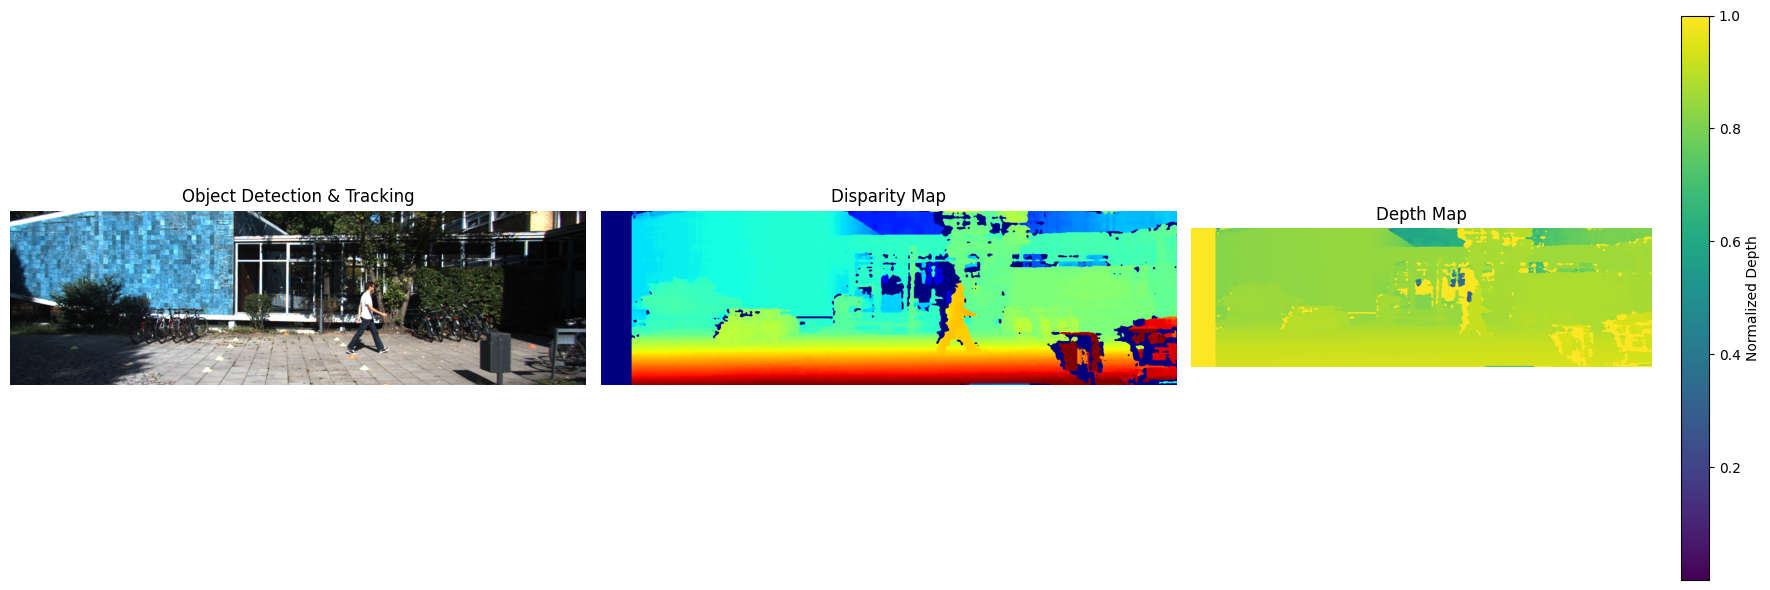


0: 224x640 1 car, 54.9ms
Speed: 9.7ms preprocess, 54.9ms inference, 23.0ms postprocess per image at shape (1, 3, 224, 640)


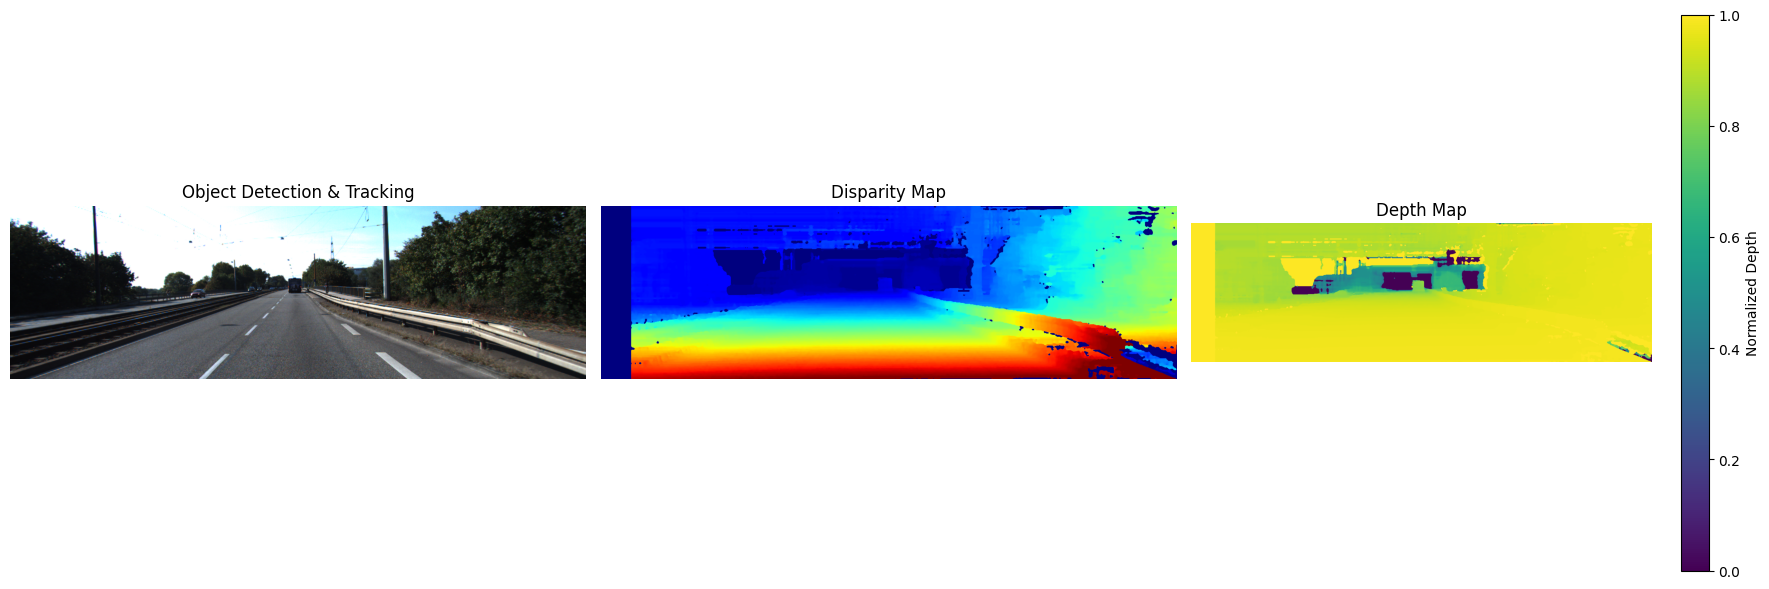


0: 224x640 1 car, 50.1ms
Speed: 6.2ms preprocess, 50.1ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 640)


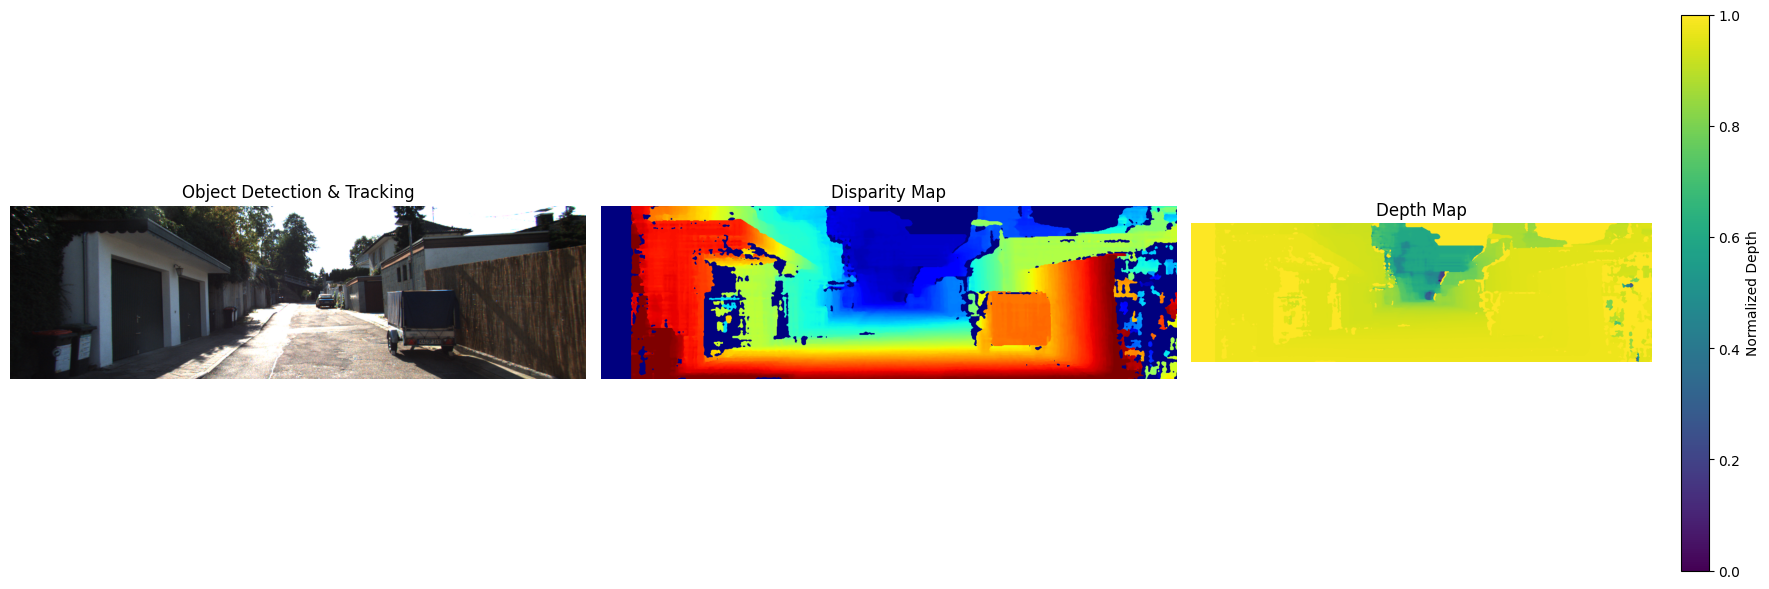


0: 224x640 2 cars, 44.5ms
Speed: 3.5ms preprocess, 44.5ms inference, 5.7ms postprocess per image at shape (1, 3, 224, 640)


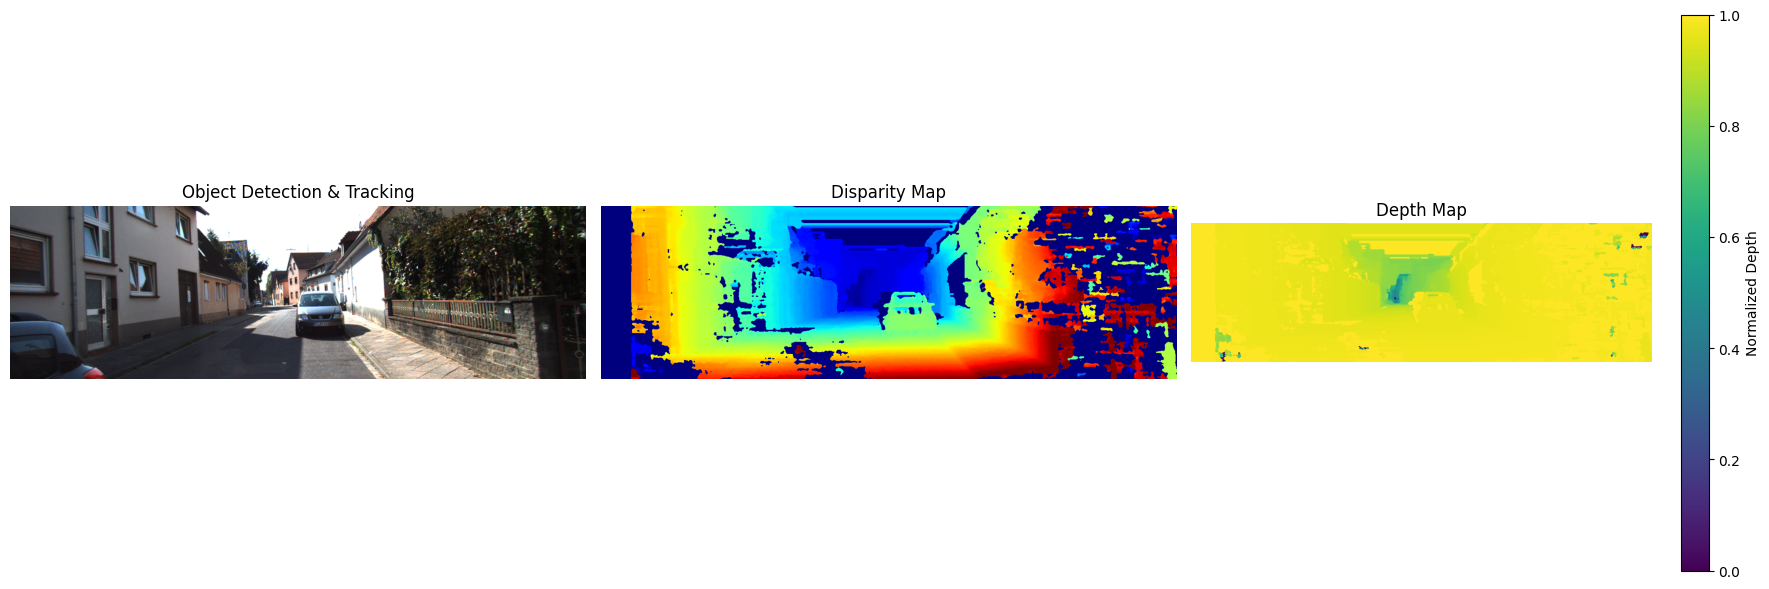


0: 224x640 (no detections), 33.0ms
Speed: 7.1ms preprocess, 33.0ms inference, 9.7ms postprocess per image at shape (1, 3, 224, 640)


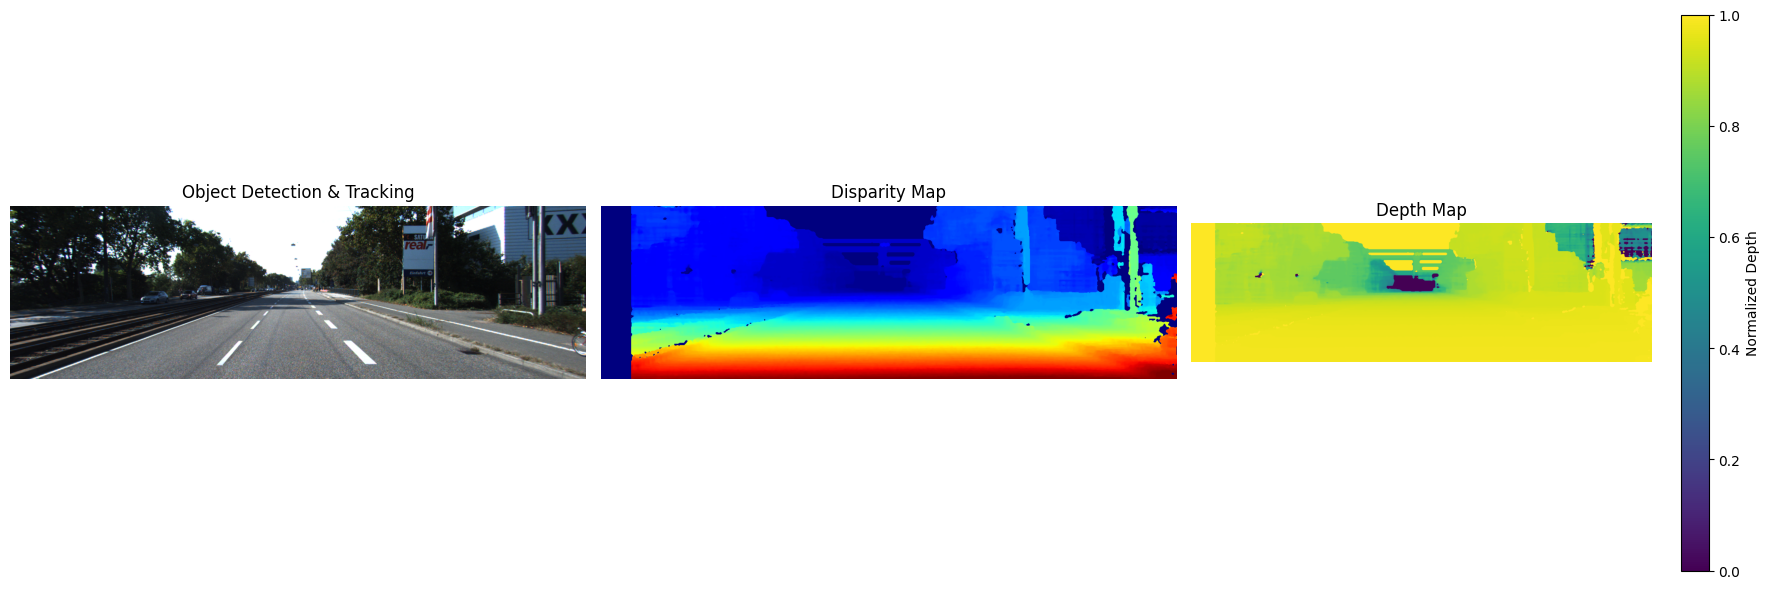

No tracks available for analysis!


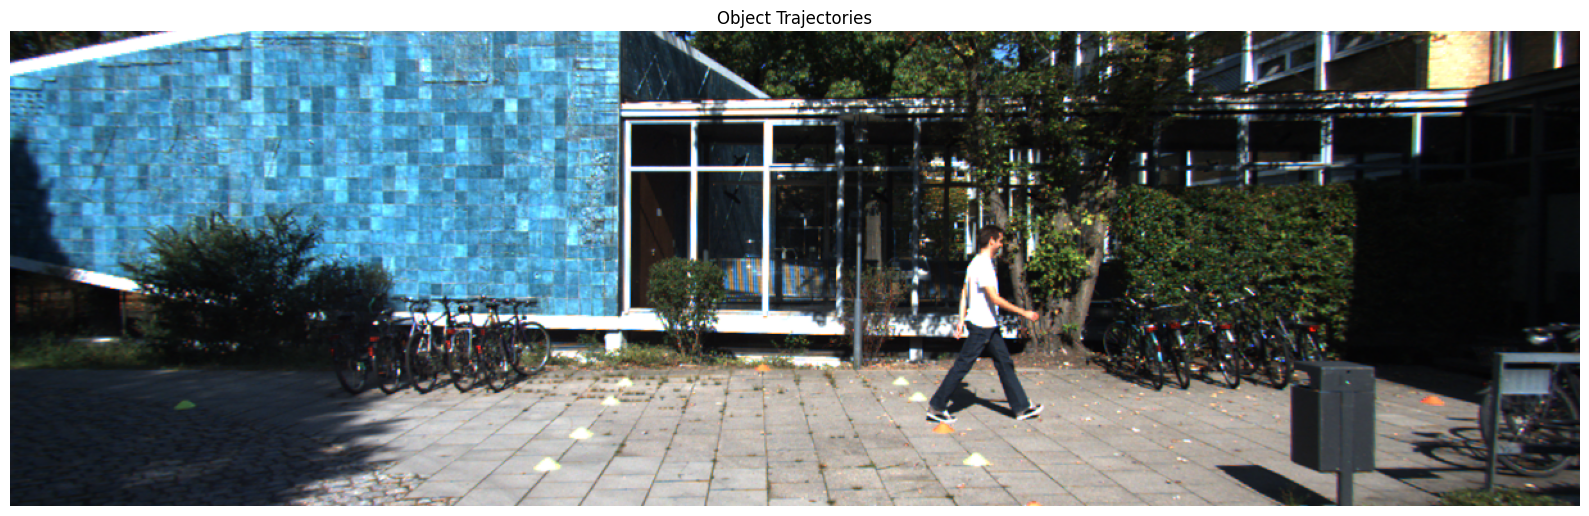

Processing complete!


In [9]:
# Configuration
LEFT_IMG_PATH = os.path.join(path, 'data_object_image_2/training/image_2')
RIGHT_IMG_PATH = os.path.join(path, 'data_object_image_3/training/image_3')
CALIB_PATH = os.path.join(path, 'data_object_calib/training/calib')
LABEL_PATH = os.path.join(path, 'data_object_label_2/training/label_2')


YOLO_MODEL_PATH = '/kaggle/input/kitti-dataset/yolov8n_kitti.pt'

class IntegratedPerceptionSystem:
    def __init__(self, yolo_model_path=None):
        """Initialize the integrated perception system"""
        # Load YOLOv8 model
        if yolo_model_path and os.path.exists(yolo_model_path):
            self.detector = YOLO(yolo_model_path)
        else:
            print("Using pretrained YOLOv8 model (nano version)")
            self.detector = YOLO("yolov8n.pt")

        # Initialize DeepSORT tracker
        self.tracker = DeepSort(
            max_cosine_distance=0.3,
            nn_budget=None,
            max_age=50,
            n_init=2
        )

        # Dictionary to keep track of objects
        self.tracks = defaultdict(list)
        self.track_colors = {}

        # Class name mapping between YOLO and KITTI
        self.kitti_to_yolo = {
            'Car': 2,       # COCO: car
            'Van': 2,       # COCO: car
            'Truck': 7,     # COCO: truck
            'Pedestrian': 0, # COCO: person
            'Person_sitting': 0, # COCO: person
            'Cyclist': 1,   # COCO: bicycle (rider)
            'Tram': 6,      # COCO: train (closest match)
            'Misc': None,
            'DontCare': None
        }

        # Load COCO class names for visualization
        self.class_names = self.detector.names

    def read_calibration(self, calib_file_path):
        """Read calibration file and extract camera parameters"""
        calib_data = {}
        with open(calib_file_path, 'r') as f:
            for line in f.readlines():
                if ':' in line:
                    key, value = line.split(':', 1)
                    calib_data[key] = np.array([float(x) for x in value.split()])

        # Extract projection matrices
        if 'P2' in calib_data:
            P2 = calib_data['P2'].reshape(3, 4)
            calib_data['P2_matrix'] = P2

        if 'P3' in calib_data:
            P3 = calib_data['P3'].reshape(3, 4)
            calib_data['P3_matrix'] = P3

        # Extract camera parameters for stereo
        if 'P2_matrix' in calib_data and 'P3_matrix' in calib_data:
            # Focal length (assuming same for both cameras)
            calib_data['focal_length'] = calib_data['P2_matrix'][0, 0]

            # Baseline (distance between cameras)
            calib_data['baseline'] = calib_data['P3_matrix'][0, 3] - calib_data['P2_matrix'][0, 3]

            # Principal points
            calib_data['cx1'] = calib_data['P2_matrix'][0, 2]
            calib_data['cy1'] = calib_data['P2_matrix'][1, 2]
            calib_data['cx2'] = calib_data['P3_matrix'][0, 2]
            calib_data['cy2'] = calib_data['P3_matrix'][1, 2]

        return calib_data

    def compute_disparity_map(self, left_img, right_img):
        """Compute disparity map using SGBM algorithm with robust parameters"""
        # Convert to grayscale if color
        if len(left_img.shape) == 3:
            left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
            right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
        else:
            left_gray = left_img
            right_gray = right_img

        # SGBM Parameters - adjusted for better results
        window_size = 3
        min_disp = 1
        num_disp = 64  # Must be divisible by 16

        stereo = cv2.StereoSGBM_create(
            minDisparity=min_disp,
            numDisparities=num_disp,
            blockSize=window_size,
            P1=8 * 3 * window_size**2,
            P2=32 * 3 * window_size**2,
            disp12MaxDiff=1,
            uniquenessRatio=10,
            speckleWindowSize=100,
            speckleRange=2,
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
        )

        # Compute disparity
        disparity = stereo.compute(left_gray, right_gray).astype(np.float32) / 16.0

        # Post-process disparity map
        # Apply median filter to reduce noise
        disparity = cv2.medianBlur(disparity, 5)

        return disparity

    def disparity_to_depth(self, disparity, focal_length, baseline):
        """Convert disparity map to depth map with robust handling of invalid values"""
        # Avoid division by zero and very small values
        min_disparity = 0.1  # Minimum valid disparity value

        # Create mask for valid disparity values
        mask = disparity > min_disparity

        # Initialize depth map
        depth = np.zeros_like(disparity)

        # Calculate depth only for valid disparities
        if np.any(mask):
            depth[mask] = (focal_length * baseline) / disparity[mask]

            # Filter out extreme values
            max_depth = 80.0  # Maximum valid depth in meters
            depth[depth > max_depth] = max_depth

        return depth, mask

    def detect_objects(self, frame, conf_threshold=0.1):
        """Detect objects in a frame using YOLOv8"""
        results = self.detector(frame, conf=conf_threshold)[0]

        # Extract bounding boxes, confidence scores, and class IDs
        boxes = []
        scores = []
        class_ids = []

        for det in results.boxes.data.cpu().numpy():
            x1, y1, x2, y2, conf, class_id = det
            boxes.append([int(x1), int(y1), int(x2), int(y2)])
            scores.append(conf)
            class_ids.append(int(class_id))

        return boxes, scores, class_ids

    def estimate_object_distance(self, depth_map, bbox, valid_depth_mask=None):
        """Estimate object distance using depth map with robust handling"""
        x1, y1, x2, y2 = bbox

        # Ensure bbox coordinates are within image bounds
        h, w = depth_map.shape
        x1 = max(0, int(x1))
        y1 = max(0, int(y1))
        x2 = min(w-1, int(x2))
        y2 = min(h-1, int(y2))

        # Skip invalid bounding boxes
        if x1 >= x2 or y1 >= y2:
            return None

        # Extract depth values within the bounding box
        bbox_depth = depth_map[y1:y2, x1:x2]

        # Apply valid depth mask if provided
        if valid_depth_mask is not None:
            bbox_valid_mask = valid_depth_mask[y1:y2, x1:x2]
            valid_depths = bbox_depth[bbox_valid_mask]
        else:
            valid_depths = bbox_depth[bbox_depth > 0]

        if len(valid_depths) == 0:
            return None

        # Use percentile instead of median for more robust distance estimation
        # (lower percentile focuses on closer points, which are often more reliable)
        distance = np.percentile(valid_depths, 25)

        return distance

    def update_tracks(self, frame, boxes, scores, class_ids, depths=None):
        """Update object tracks using DeepSORT with depth information"""
        # Prepare detections for DeepSORT
        detections = []
        for i, (bbox, score, class_id) in enumerate(zip(boxes, scores, class_ids)):
            # DeepSORT expects [left, top, width, height] format
            x1, y1, x2, y2 = bbox
            w, h = x2 - x1, y2 - y1

            # Skip detections with zero width or height
            if w <= 0 or h <= 0:
                continue

            # Add detection with distance if available
            detection_info = ([x1, y1, w, h], score, class_id)
            detections.append(detection_info)

        # Update tracker
        tracks = self.tracker.update_tracks(detections, frame=frame)

        # Process tracks
        active_tracks = []
        for track in tracks:
            if not track.is_confirmed():
                continue

            track_id = track.track_id
            ltrb = track.to_ltrb()  # left, top, right, bottom
            class_id = track.get_det_class()

            # Generate a consistent color for this track ID
            if track_id not in self.track_colors:
                # Use distinct colors for different tracks
                self.track_colors[track_id] = np.random.rand(3)

            # Find distance if available
            distance = None
            if depths is not None:
                # Find index of this track in the original detections
                for i, (bbox, _, det_class_id) in enumerate(detections):
                    x, y, w, h = bbox
                    det_ltrb = [x, y, x+w, y+h]

                    # Check if this detection matches this track
                    if class_id == det_class_id and self._iou(ltrb, det_ltrb) > 0.5:
                        if i < len(depths) and depths[i] is not None:
                            distance = depths[i]
                            break

            # Add to the track history
            self.tracks[track_id].append({
                'bbox': ltrb,
                'class_id': class_id,
                'frame_idx': len(self.tracks[track_id]),
                'distance': distance
            })

            active_tracks.append({
                'id': track_id,
                'bbox': ltrb,
                'class_id': class_id,
                'color': self.track_colors[track_id],
                'distance': distance
            })

        return active_tracks

    def _iou(self, bbox1, bbox2):
        """Calculate IoU between two bounding boxes"""
        # Get coordinates
        x1_1, y1_1, x2_1, y2_1 = bbox1
        x1_2, y1_2, x2_2, y2_2 = bbox2

        # Calculate intersection
        x1_i = max(x1_1, x1_2)
        y1_i = max(y1_1, y1_2)
        x2_i = min(x2_1, x2_2)
        y2_i = min(y2_1, y2_2)

        if x2_i < x1_i or y2_i < y1_i:
            return 0.0

        intersection = (x2_i - x1_i) * (y2_i - y1_i)

        # Calculate areas
        area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
        area2 = (x2_2 - x1_2) * (y2_2 - y1_2)

        # Calculate IoU
        union = area1 + area2 - intersection
        iou = intersection / union if union > 0 else 0.0

        return iou

    def draw_tracks(self, frame, tracks):
        """Draw tracks on the frame with distance information"""
        frame_draw = frame.copy()

        for track in tracks:
            # Extract track information
            track_id = track['id']
            x1, y1, x2, y2 = track['bbox']
            class_id = track['class_id']
            color = track['color']
            distance = track.get('distance', None)

            # Convert from float32 to int for OpenCV
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            # Get class name if available
            class_name = self.class_names.get(class_id, f"Class {class_id}")

            # Convert RGB color to BGR for OpenCV
            bgr_color = (int(color[2] * 255), int(color[1] * 255), int(color[0] * 255))

            # Draw bounding box
            cv2.rectangle(frame_draw, (x1, y1), (x2, y2), bgr_color, 2)

            # Create label with track ID, class, and distance if available
            if distance is not None:
                label = f"ID:{track_id} {class_name} {distance:.1f}m"
            else:
                label = f"ID:{track_id} {class_name}"

            # Draw filled rectangle for text background
            label_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            cv2.rectangle(
                frame_draw,
                (x1, y1 - label_size[1] - 10),
                (x1 + label_size[0], y1),
                bgr_color,
                -1
            )

            # Draw text
            cv2.putText(
                frame_draw,
                label,
                (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 255, 255),
                2
            )

        return frame_draw

    def process_frame(self, left_img, right_img, calib_data, conf_threshold=0.25):
        """Process a single frame with detection, depth estimation, and tracking"""
        # Ensure images are in RGB for detection
        if len(left_img.shape) == 2 or left_img.shape[2] == 1:
            left_img_rgb = cv2.cvtColor(left_img, cv2.COLOR_GRAY2RGB)
        elif left_img.shape[2] == 3 and left_img.dtype == np.uint8:
            left_img_rgb = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
        else:
            left_img_rgb = left_img.copy()

        # Detect objects
        boxes, scores, class_ids = self.detect_objects(left_img_rgb, conf_threshold)

        # Compute disparity and depth
        try:
            disparity = self.compute_disparity_map(left_img, right_img)
            depth_map, valid_mask = self.disparity_to_depth(
                disparity,
                calib_data['focal_length'],
                calib_data['baseline']
            )

            # Estimate distances for each detection
            distances = []
            for box in boxes:
                distance = self.estimate_object_distance(depth_map, box, valid_mask)
                distances.append(distance)
        except Exception as e:
            print(f"Error in depth estimation: {e}")
            depth_map = None
            valid_mask = None
            distances = [None] * len(boxes)

        # Update tracking
        tracks = self.update_tracks(left_img_rgb, boxes, scores, class_ids, distances)

        # Create visualization
        if depth_map is not None:
            has_depth = True
        else:
            has_depth = False

        return {
            'boxes': boxes,
            'scores': scores,
            'class_ids': class_ids,
            'disparity': disparity if 'disparity' in locals() else None,
            'depth_map': depth_map,
            'valid_mask': valid_mask if 'valid_mask' in locals() else None,
            'tracks': tracks,
            'distances': distances,
            'has_depth': has_depth
        }

    def process_sequence(self, start_idx, num_frames, conf_threshold=0.25):
        """Process a sequence of frames"""
        # Clear previous tracks
        self.tracks = defaultdict(list)
        self.track_colors = {}

        results = []

        # Process each frame
        for i in tqdm(range(start_idx, start_idx + num_frames)):
            # Get file number with padding
            file_idx = f"{i:06d}"

            # Load image paths
            left_img_path = os.path.join(LEFT_IMG_PATH, f"{file_idx}.png")
            right_img_path = os.path.join(RIGHT_IMG_PATH, f"{file_idx}.png")
            calib_file_path = os.path.join(CALIB_PATH, f"{file_idx}.txt")

            if not all(os.path.exists(p) for p in [left_img_path, right_img_path, calib_file_path]):
                print(f"Files for frame {i} don't exist, skipping...")
                continue

            # Read images
            left_img = cv2.imread(left_img_path)
            right_img = cv2.imread(right_img_path)

            # Read calibration
            calib_data = self.read_calibration(calib_file_path)

            # Process frame
            frame_result = self.process_frame(left_img, right_img, calib_data, conf_threshold)
            frame_result['frame_idx'] = i
            frame_result['left_img'] = left_img

            # Add to results
            results.append(frame_result)

            self.visualize_frame_results(frame_result, left_img)

        return results

    def visualize_frame_results(self, results, left_img):
        """Visualize results for a single frame"""
        # Create RGB version of left image for visualization
        left_img_rgb = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)

        # Draw tracks
        tracked_img = self.draw_tracks(left_img_rgb, results['tracks'])

        # Setup visualization with or without depth
        if results['has_depth'] and results['depth_map'] is not None:
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))

            # Original image with tracking
            axes[0].imshow(tracked_img)
            axes[0].set_title('Object Detection & Tracking')
            axes[0].axis('off')

            # Disparity map
            if results['disparity'] is not None:
                disparity_normalized = cv2.normalize(
                    results['disparity'],
                    None,
                    alpha=0,
                    beta=1,
                    norm_type=cv2.NORM_MINMAX,
                    dtype=cv2.CV_32F
                )
                axes[1].imshow(disparity_normalized, cmap='jet')
                axes[1].set_title('Disparity Map')
                axes[1].axis('off')

            # Depth map
            depth_normalized = cv2.normalize(
                results['depth_map'],
                None,
                alpha=0,
                beta=1,
                norm_type=cv2.NORM_MINMAX,
                dtype=cv2.CV_32F
            )
            im = axes[2].imshow(depth_normalized, cmap='viridis')
            axes[2].set_title('Depth Map')
            axes[2].axis('off')

            # Add colorbar
            cbar = fig.colorbar(im, ax=axes[2])
            cbar.set_label('Normalized Depth')
        else:
            # Just show detection and tracking
            plt.figure(figsize=(12, 8))
            plt.imshow(tracked_img)
            plt.title('Object Detection & Tracking')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    def analyze_tracking_results(self, results):
        """Analyze and visualize tracking statistics"""
        if len(self.tracks) == 0:
            print("No tracks available for analysis!")
            return

        # Calculate track statistics
        track_lengths = [len(detections) for track_id, detections in self.tracks.items()]

        # Get class distribution
        class_counts = defaultdict(int)
        for track_id, detections in self.tracks.items():
            if len(detections) > 0:
                # Use most common class in the track
                class_ids = [det['class_id'] for det in detections]
                most_common_class = max(set(class_ids), key=class_ids.count)
                class_name = self.class_names.get(most_common_class, f"Class {most_common_class}")
                class_counts[class_name] += 1

        # Plot track statistics
        plt.figure(figsize=(16, 6))

        # Track length histogram
        plt.subplot(1, 2, 1)
        plt.hist(track_lengths, bins=10, color='skyblue', edgecolor='black')
        plt.xlabel('Track Length (frames)')
        plt.ylabel('Count')
        plt.title('Track Duration Distribution')

        # Class distribution
        plt.subplot(1, 2, 2)
        classes = list(class_counts.keys())
        counts = list(class_counts.values())
        plt.bar(classes, counts, color='lightgreen')
        plt.xlabel('Object Class')
        plt.ylabel('Count')
        plt.title('Tracked Object Class Distribution')
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\nTracking Summary:")
        print(f"Total frames processed: {len(results)}")
        print(f"Total unique objects tracked: {len(self.tracks)}")
        print(f"Average track length: {np.mean(track_lengths):.2f} frames")
        print(f"Maximum track length: {np.max(track_lengths)} frames")
        print(f"Minimum track length: {np.min(track_lengths)} frames")
        print("\nObject classes:")
        for class_name, count in class_counts.items():
            print(f"  - {class_name}: {count}")

    def visualize_trajectory_map(self, first_frame_img):
        """Visualize object trajectories on the first frame"""
        plt.figure(figsize=(16, 10))

        # Use the first frame as background
        plt.imshow(cv2.cvtColor(first_frame_img, cv2.COLOR_BGR2RGB))

        # Plot trajectories for each track
        for track_id, detections in self.tracks.items():
            if len(detections) < 3:  # Skip short tracks
                continue

            # Get color for this track
            color = self.track_colors.get(track_id, np.random.rand(3))

            # Extract trajectory points (centers of bounding boxes)
            xs = []
            ys = []
            for det in detections:
                x1, y1, x2, y2 = det['bbox']
                center_x = (x1 + x2) / 2
                center_y = (y1 + y2) / 2
                xs.append(center_x)
                ys.append(center_y)

            # Plot trajectory line
            plt.plot(xs, ys, '-', color=color, linewidth=2, alpha=0.7)

            # Plot start point (larger)
            plt.plot(xs[0], ys[0], 'o', color=color, markersize=8)

            # Plot end point (with '×' marker)
            plt.plot(xs[-1], ys[-1], 'x', color=color, markersize=8)

            # Add track ID text
            plt.text(
                xs[-1] + 5, ys[-1] + 5,
                f"{track_id}",
                color=color,
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.7)
            )

        plt.title("Object Trajectories")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def run_integrated_perception(start_idx=0, num_frames=10, conf_threshold=0.25, model_path=None):
    """Run the integrated perception system on a sequence of KITTI frames

    Args:
        start_idx: Starting frame index
        num_frames: Number of frames to process
        conf_threshold: Confidence threshold for detection
        model_path: Path to the fine-tuned YOLOv8 model
    """
    # Initialize system with the specified model
    system = IntegratedPerceptionSystem(model_path)

    # Process sequence
    print(f"Processing {num_frames} frames starting from index {start_idx}...")
    results = system.process_sequence(start_idx, num_frames, conf_threshold)

    if len(results) == 0:
        print("No frames were processed successfully!")
        return system, None

    # Analyze results
    system.analyze_tracking_results(results)

    # Visualize trajectories on first frame
    if len(results) > 0:
        system.visualize_trajectory_map(results[0]['left_img'])

    print("Processing complete!")
    return system, results

# Example usage
if __name__ == "__main__":

    if not all(os.path.exists(p) for p in [LEFT_IMG_PATH, RIGHT_IMG_PATH, CALIB_PATH, LABEL_PATH]):
        print("Warning: Some dataset paths don't exist! Check your paths.")

    # Find first available image
    image_files = sorted([f for f in os.listdir(LEFT_IMG_PATH) if f.endswith('.png')])
    if len(image_files) > 0:

        start_idx = int(os.path.splitext(image_files[0])[0])
        print(f"Using start index: {start_idx}")

        # Run integrated perception system
        system, results = run_integrated_perception(start_idx=start_idx, num_frames=5, model_path = YOLO_MODEL_PATH)
    else:
        print("No image files found!")

# **Evaluation Metrics**

In [10]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML

class EvaluationDashboard:
    """Dashboard for evaluating 3D object detection and tracking"""

    def __init__(self, system=None, results=None):
        """Initialize with system and results"""
        self.system = system
        self.results = results
        self.metrics = {
            'detection': {},
            'tracking': {},
            '3D': {}
        }
        self.class_names = system.class_names if system else {}

    def calculate_metrics(self):
        """Calculate metrics from system and results"""
        if not self.system or not self.results:
            print("No system or results to evaluate")
            return

        # Extract detection metrics
        self._calculate_detection_metrics()

        # Extract tracking metrics
        self._calculate_tracking_metrics()

        # Extract 3D metrics
        self._calculate_3d_metrics()

    def _calculate_detection_metrics(self):
        """Calculate detection metrics"""
        # Initialize detection metrics
        detection_metrics = {
            'class_counts': defaultdict(int),
            'avg_confidence': defaultdict(list),
            'total_detections': 0
        }

        # Collect metrics from all frames
        for frame in self.results:
            boxes = frame.get('boxes', [])
            scores = frame.get('scores', [])
            class_ids = frame.get('class_ids', [])

            for i, (box, score, class_id) in enumerate(zip(boxes, scores, class_ids)):
                class_name = self.class_names.get(class_id, f"Class {class_id}")
                detection_metrics['class_counts'][class_name] += 1
                detection_metrics['total_detections'] += 1
                detection_metrics['avg_confidence'][class_name].append(score)

        # Calculate average confidence per class
        for class_name, confs in detection_metrics['avg_confidence'].items():
            if confs:
                detection_metrics['avg_confidence'][class_name] = np.mean(confs)
            else:
                detection_metrics['avg_confidence'][class_name] = 0.0

        self.metrics['detection'] = detection_metrics

    def _calculate_tracking_metrics(self):
        """Calculate tracking metrics"""
        # Get tracks from system
        tracks = self.system.tracks

        # Initialize tracking metrics
        tracking_metrics = {
            'total_tracks': len(tracks),
            'track_lengths': {},
            'track_classes': defaultdict(int),
            'avg_track_length': 0
        }

        # Calculate track lengths and classes
        for track_id, detections in tracks.items():
            track_length = len(detections)

            # Get most common class
            if detections:
                class_ids = [det.get('class_id', -1) for det in detections]
                most_common = max(set(class_ids), key=class_ids.count)
                class_name = self.class_names.get(most_common, f"Class {most_common}")
                tracking_metrics['track_classes'][class_name] += 1

                # Store track length by class
                if class_name not in tracking_metrics['track_lengths']:
                    tracking_metrics['track_lengths'][class_name] = []
                tracking_metrics['track_lengths'][class_name].append(track_length)

        # Calculate average track length per class and overall
        all_lengths = []
        for class_name, lengths in tracking_metrics['track_lengths'].items():
            if lengths:
                tracking_metrics[f'avg_length_{class_name}'] = np.mean(lengths)
                all_lengths.extend(lengths)
            else:
                tracking_metrics[f'avg_length_{class_name}'] = 0

        if all_lengths:
            tracking_metrics['avg_track_length'] = np.mean(all_lengths)

        self.metrics['tracking'] = tracking_metrics

    def _calculate_3d_metrics(self):
        """Calculate 3D metrics"""
        # Initialize 3D metrics
        metrics_3d = {
            'valid_depth_frames': 0,
            'avg_depth': 0,
            'distance_errors': []
        }

        valid_depths = []

        # Count frames with valid depth
        for frame in self.results:
            if frame.get('has_depth', False) and frame.get('depth_map') is not None:
                metrics_3d['valid_depth_frames'] += 1

                # Get valid depth values
                depth_map = frame['depth_map']
                valid_mask = depth_map > 0
                if np.any(valid_mask):
                    valid_depths.append(np.mean(depth_map[valid_mask]))

                # Calculate distance errors where possible
                if 'distances' in frame:
                    for distance in frame['distances']:
                        if distance is not None:
                            metrics_3d['distance_errors'].append(distance)

        # Calculate average depth
        if valid_depths:
            metrics_3d['avg_depth'] = np.mean(valid_depths)

        self.metrics['3D'] = metrics_3d

    def generate_dashboard(self):
        """Generate an interactive dashboard for evaluation"""
        # Calculate metrics if not already done
        if not self.metrics['detection'] and self.system and self.results:
            self.calculate_metrics()

        # Display dashboard header
        self._display_header()

        # Display key metrics summary
        self._display_key_metrics()

        # Display detection metrics
        self._display_detection_metrics()

        # Display tracking metrics
        self._display_tracking_metrics()

        # Display 3D metrics
        self._display_3d_metrics()

        # Display recommendations
        self._display_recommendations()

    def _display_header(self):
        """Display dashboard header"""
        header_html = """
        <style>
        .dashboard-header {
            background: linear-gradient(to right, #4b6cb7, #182848);
            color: white;
            padding: 20px;
            text-align: center;
            border-radius: 10px;
            margin-bottom: 20px;
            font-family: Arial, sans-serif;
        }
        .metrics-container {
            display: flex;
            flex-wrap: wrap;
            justify-content: space-around;
            margin-bottom: 20px;
        }
        .metric-box {
            background-color: #f5f5f5;
            border-radius: 8px;
            padding: 15px;
            margin: 10px;
            box-shadow: 0 4px 8px rgba(0,0,0,0.1);
            text-align: center;
            flex: 1;
            min-width: 150px;
            max-width: 200px;
        }
        .metric-value {
            font-size: 24px;
            font-weight: bold;
            color: #4b6cb7;
        }
        .metric-name {
            font-size: 14px;
            color: #666;
        }
        .section-header {
            background-color: #f0f0f0;
            padding: 10px;
            margin: 15px 0;
            border-left: 5px solid #4b6cb7;
            font-family: Arial, sans-serif;
        }
        .recommendation {
            background-color: #fffacd;
            padding: 15px;
            border-left: 5px solid #ffd700;
            margin: 20px 0;
        }
        </style>
        <div class="dashboard-header">
            <h1>3D Object Detection & Tracking Evaluation Dashboard</h1>
            <p>Performance Analysis for KITTI Dataset</p>
        </div>
        """
        display(HTML(header_html))

    def _display_key_metrics(self):
        """Display key metrics summary"""
        # Get detection metrics
        detection = self.metrics['detection']
        tracking = self.metrics['tracking']
        metrics_3d = self.metrics['3D']

        # Create key metrics
        key_metrics = [
            {'name': 'Total Detections', 'value': detection.get('total_detections', 0)},
            {'name': 'Total Tracks', 'value': tracking.get('total_tracks', 0)},
            {'name': 'Avg Track Length', 'value': f"{tracking.get('avg_track_length', 0):.1f} frames"},
            {'name': 'Valid Depth Frames', 'value': f"{metrics_3d.get('valid_depth_frames', 0)}/{len(self.results) if self.results else 0}"}
        ]

        # Generate HTML
        metrics_html = '<div class="metrics-container">'
        for metric in key_metrics:
            metrics_html += f"""
            <div class="metric-box">
                <div class="metric-value">{metric['value']}</div>
                <div class="metric-name">{metric['name']}</div>
            </div>
            """
        metrics_html += '</div>'

        display(HTML(metrics_html))

    def _display_detection_metrics(self):
        """Display detection metrics"""
        detection = self.metrics['detection']

        # Display section header
        display(HTML('<div class="section-header"><h2>Detection Performance</h2></div>'))

        # Create detection metrics charts
        if detection:
            # Class distribution
            class_counts = detection['class_counts']
            if class_counts:
                classes = list(class_counts.keys())
                counts = list(class_counts.values())

                # Create a dataframe for plotting
                df = pd.DataFrame({
                    'Class': classes,
                    'Count': counts
                })

                # Sort by count
                df = df.sort_values('Count', ascending=False)

                # Plot using Plotly
                fig = px.bar(
                    df,
                    x='Class',
                    y='Count',
                    title='Detection Count by Object Class',
                    color='Count',
                    color_continuous_scale='Viridis'
                )

                fig.update_layout(
                    xaxis_title="Object Class",
                    yaxis_title="Detection Count",
                    height=500
                )

                fig.show()

            # Class confidence
            avg_confidence = detection['avg_confidence']
            if avg_confidence:
                classes = list(avg_confidence.keys())
                confidences = list(avg_confidence.values())

                # Create a dataframe for plotting
                df = pd.DataFrame({
                    'Class': classes,
                    'Confidence': confidences
                })

                # Sort by confidence
                df = df.sort_values('Confidence', ascending=False)

                # Plot using Plotly
                fig = px.bar(
                    df,
                    x='Class',
                    y='Confidence',
                    title='Average Detection Confidence by Object Class',
                    color='Confidence',
                    color_continuous_scale='RdYlGn'
                )

                fig.update_layout(
                    xaxis_title="Object Class",
                    yaxis_title="Average Confidence",
                    height=500,
                    yaxis_range=[0, 1]
                )

                fig.show()

    def _display_tracking_metrics(self):
        """Display tracking metrics"""
        tracking = self.metrics['tracking']

        # Display section header
        display(HTML('<div class="section-header"><h2>Tracking Performance</h2></div>'))

        # Create tracking metrics charts
        if tracking:
            # Track class distribution
            track_classes = tracking['track_classes']
            if track_classes:
                classes = list(track_classes.keys())
                counts = list(track_classes.values())

                # Create a dataframe for plotting
                df = pd.DataFrame({
                    'Class': classes,
                    'Count': counts
                })

                # Sort by count
                df = df.sort_values('Count', ascending=False)

                # Plot using Plotly
                fig = px.bar(
                    df,
                    x='Class',
                    y='Count',
                    title='Unique Tracked Objects by Class',
                    color='Count',
                    color_continuous_scale='Viridis'
                )

                fig.update_layout(
                    xaxis_title="Object Class",
                    yaxis_title="Track Count",
                    height=500
                )

                fig.show()

            # Track length by class
            track_lengths = tracking['track_lengths']
            if track_lengths:
                # Prepare data for box plot
                fig = go.Figure()

                for class_name, lengths in track_lengths.items():
                    if lengths:
                        fig.add_trace(go.Box(
                            y=lengths,
                            name=class_name,
                            boxpoints='all',
                            jitter=0.3,
                            pointpos=-1.8
                        ))

                fig.update_layout(
                    title='Track Duration Distribution by Class',
                    yaxis_title='Track Length (frames)',
                    height=600,
                    boxmode='group'
                )

                fig.show()

                # Show trajectory example if available
                if self.system and self.results and len(self.results) > 0:
                    # Get first frame for trajectory visualization
                    first_frame = self.results[0].get('left_img')
                    if first_frame is not None:
                        plt.figure(figsize=(12, 8))
                        plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))

                        # Plot trajectories
                        for track_id, detections in self.system.tracks.items():
                            if len(detections) < 3:  # Skip short tracks
                                continue

                            # Get color
                            color = self.system.track_colors.get(track_id, np.random.rand(3))

                            # Extract centers
                            centers_x = []
                            centers_y = []
                            for det in detections:
                                x1, y1, x2, y2 = det['bbox']
                                center_x = (x1 + x2) / 2
                                center_y = (y1 + y2) / 2
                                centers_x.append(center_x)
                                centers_y.append(center_y)

                            # Plot trajectory
                            plt.plot(centers_x, centers_y, '-', color=color, linewidth=2, alpha=0.7)
                            plt.plot(centers_x[0], centers_y[0], 'o', color=color, markersize=6)
                            plt.plot(centers_x[-1], centers_y[-1], 'x', color=color, markersize=6)

                            # Add track ID
                            plt.text(
                                centers_x[-1] + 5, centers_y[-1] + 5,
                                f"{track_id}",
                                color=color,
                                bbox=dict(facecolor='white', alpha=0.7)
                            )

                        plt.title("Object Trajectories")
                        plt.axis('off')
                        plt.tight_layout()
                        plt.show()

    def _display_3d_metrics(self):
        """Display 3D metrics"""
        metrics_3d = self.metrics['3D']

        # Display section header
        display(HTML('<div class="section-header"><h2>3D Detection & Depth Estimation</h2></div>'))

        # Create 3D metrics charts
        if metrics_3d:
            # Depth frame availability
            valid_frames = metrics_3d.get('valid_depth_frames', 0)
            total_frames = len(self.results) if self.results else 0

            if total_frames > 0:
                labels = ['Valid Depth', 'Missing Depth']
                values = [valid_frames, total_frames - valid_frames]

                fig = px.pie(
                    names=labels,
                    values=values,
                    title='Depth Map Availability',
                    color_discrete_sequence=['#2ecc71', '#e74c3c']
                )

                fig.update_traces(textinfo='percent+label')
                fig.update_layout(height=500)

                fig.show()

            # Distance errors histogram if available
            distance_errors = metrics_3d.get('distance_errors', [])
            if distance_errors:
                fig = px.histogram(
                    distance_errors,
                    title='Object Distance Distribution',
                    labels={'value': 'Distance (meters)'},
                    color_discrete_sequence=['#3498db']
                )

                fig.update_layout(
                    xaxis_title='Distance (meters)',
                    yaxis_title='Count',
                    height=500
                )

                # Add mean line
                mean_distance = np.mean(distance_errors)
                fig.add_vline(
                    x=mean_distance,
                    line_dash="dash",
                    line_color="red",
                    annotation_text=f"Mean: {mean_distance:.2f}m",
                    annotation_position="top right"
                )

                fig.show()

    def _display_recommendations(self):
        """Display system recommendations"""
        detection = self.metrics['detection']
        tracking = self.metrics['tracking']
        metrics_3d = self.metrics['3D']

        # Generate recommendations
        recommendations = []

        # Detection recommendations
        if detection:
            # Check if any class has very low detections
            class_counts = detection['class_counts']
            avg_confidence = detection['avg_confidence']

            if class_counts:
                total_dets = sum(class_counts.values())
                for cls, count in class_counts.items():
                    if count < 5 and total_dets > 20:
                        recommendations.append(f"Low detection count for class '{cls}'. Consider collecting more training data for this class or adjusting model fine-tuning.")

                # Check confidence
                low_conf_classes = [cls for cls, conf in avg_confidence.items() if conf < 0.4 and class_counts.get(cls, 0) > 5]
                if low_conf_classes:
                    recommendations.append(f"Low confidence detections for classes: {', '.join(low_conf_classes)}. Consider model fine-tuning for these classes.")

        # Tracking recommendations
        if tracking:
            # Check if tracking is producing short tracks
            avg_length = tracking.get('avg_track_length', 0)
            if avg_length < 5 and tracking.get('total_tracks', 0) > 0:
                recommendations.append("Short average track length detected. Consider adjusting tracking parameters (decrease n_init or increase max_age) to improve tracking continuity.")

            # Check if very few tracks are being created
            if tracking.get('total_tracks', 0) < 3 and detection.get('total_detections', 0) > 20:
                recommendations.append("Few tracks created despite many detections. Check if detection confidence threshold is appropriate or adjust tracker parameters.")

        # 3D recommendations
        if metrics_3d:
            # Check depth map availability
            valid_frames = metrics_3d.get('valid_depth_frames', 0)
            total_frames = len(self.results) if self.results else 0

            if valid_frames < total_frames * 0.5 and total_frames > 0:
                recommendations.append(f"Low depth map availability ({valid_frames}/{total_frames} frames). Check stereo calibration or consider adjusting disparity computation parameters.")

        # Display recommendations
        if recommendations:
            html = """
            <div class="recommendation">
                <h3>System Recommendations</h3>
                <ul>
            """

            for recommendation in recommendations:
                html += f"<li>{recommendation}</li>"

            html += """
                </ul>
            </div>
            """

            display(HTML(html))
        else:
            display(HTML("""
            <div class="recommendation">
                <h3>System Recommendations</h3>
                <p>No specific recommendations at this time. The system appears to be functioning within expected parameters.</p>
            </div>
            """))

# Example usage
def evaluate_system(system, results):
    """Evaluate system and create dashboard"""
    dashboard = EvaluationDashboard(system, results)
    dashboard.calculate_metrics()
    dashboard.generate_dashboard()
    return dashboard

In [11]:

evaluate_system(system, results)

dashboard = evaluate_system(system, results)